In [133]:
from bs4 import BeautifulSoup
import requests
import tqdm
import numpy as np
import urllib.request
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Gather data

In [2]:
response = requests.get("https://xkcd.com/2400/")
print(response.status_code)

200


In [3]:
soup = BeautifulSoup(response.content, 'html.parser')

In [4]:
soup.find(id = "comic").img.get("src")

'//imgs.xkcd.com/comics/statistics.png'

In [5]:
def get_xkcd_comic(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    comic = {}
    comic["title"] = soup.find(id = "comic").img.get("alt")
    comic["img_link"] = soup.find(id = "comic").img.get("src")
    comic["comment"] = soup.find(id = "comic").img.get("title")
    return comic

In [84]:
comics = {}
for i in tqdm.tqdm(range(0, 2404)):
    try:
        comic = get_xkcd_comic(f"https://xkcd.com/{i}")
        if comic["title"] is not None:
            comics[i] = get_xkcd_comic(f"https://xkcd.com/{i}")
    except:
        continue

100%|██████████████████████████████████████████████████████████████████████████████| 2404/2404 [17:36<00:00,  2.27it/s]


# Pre-process data

In [15]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [85]:
for key in tqdm.tqdm(comics.keys()):
    try:
        doc = nlp(comics[key]["title"])
        comics[key]["title_vec"] = doc.vector
        doc = nlp(comics[key]["comment"])
        comics[key]["comment_vec"] = doc.vector
    except TypeError:
        continue

100%|██████████████████████████████████████████████████████████████████████████████| 2395/2395 [00:24<00:00, 96.63it/s]


In [86]:
for c, key in enumerate(comics.keys()):
    comics[key]["idx"] = c

In [103]:
idx_to_keys = {idx:key for key, idx in zip(comics.keys(), range(len(comics)))}

In [87]:
title_matrix = np.array([comics[key]["title_vec"] for key in comics.keys()])
comment_matrix = np.array([comics[key]["comment_vec"] for key in comics.keys()])

# Similarity

In [160]:
from IPython.display import Image 

def cosine_distance(a,b):
    return ((b - a)**2).sum(axis=1)**0.5

Title similarity
New Year's Eve


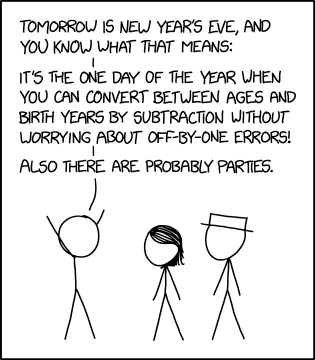

Comment similarity
Doing great here in the sixth and hopefully final year of the 2016 election.


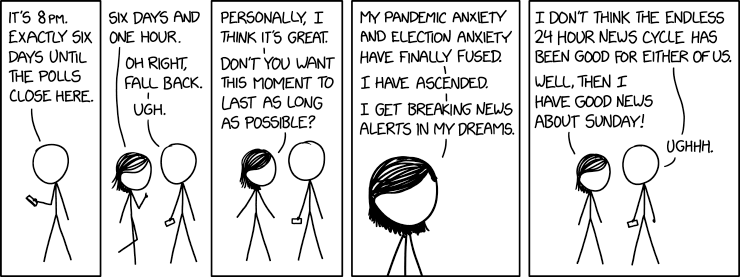

In [172]:
text = "new year"
doc = nlp(text)

print("Title similarity")
x = cosine_distance(doc.vector, title_matrix).argmin()
print(comics[idx_to_keys[x]]["title"])
img_link = r"https:" + comics[idx_to_keys[x]]["img_link"]
img = Image(img_link)
display(img)

print("Comment similarity")
x = cosine_distance(doc.vector, comment_matrix).argmin()
print(comics[idx_to_keys[x]]["comment"])
img_link = r"https:" + comics[idx_to_keys[x]]["img_link"]
img = Image(img_link)
display(img)

In [173]:
import pickle

with open('comics.pickle', 'wb') as handle:
    pickle.dump(comics, handle)

with open('title_matrix.pickle', 'wb') as handle:
    pickle.dump(title_matrix, handle)